# overlap integral normalization
#### Tom Schatteburg, 03.10.2023
### define some mode amplitude distributions, normalize them and calculate their (normalized) overlap integrals

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.special import jv, jn_zeros

### 2D, radially symmetric, analytic functions

In [2]:
def integrate_area_radial_2D(func, Rmax, args=()):
    integrand_cyl = lambda r: 2*np.pi*r * func(r,*args) # integrand in cylindrical coordinates
    int_area, _ = quad(integrand_cyl,0,Rmax)
    return int_area

def integrate_area_abs2_radial_2D(func, Rmax, args=()):
    def func_abs2(r,*args):
        return abs(func(r,*args))**2
    return integrate_area_radial_2D(func_abs2, Rmax, args=args)

def normalize_spatialfunc_radial_2D(func, Rmax, args=()):
    N = integrate_area_abs2_radial_2D(func, Rmax, args=args)
    def func_norm_2D(r,*args):
        return 1/np.sqrt(N) * func(r,*args)
    return func_norm_2D

def overlap_integral_radial_2D(func1, func2, Rmax, args=()):
    return integrate_area_radial_2D(lambda r: func1(r)*func2(r), Rmax, args=args)

#### some tests

In [3]:
# domain boundaries
Rmax = 1e-3

In [4]:
# coordinates
nr = 1000
rs = np.linspace(0, Rmax,nr)

In [5]:
# transverse mode numbers of Bessel modes
kmin = 0
kmax = 101 # transverse mode number of Bessel modes
ks = range(kmin,kmax+1)
j0_zeros = jn_zeros(0, kmax+1)

In [31]:
w=1e-4
myfunc3 = lambda r: np.exp(-r**2/w**2)
k1=4
k2=5
myfunc1 = lambda r: jv(0,j0_zeros[k1]*r/Rmax)
myfunc2 = lambda r: jv(0,j0_zeros[k2]*r/Rmax)

r_inner = 1e-4
r_outer = 2e-4
myfunc4 = np.vectorize(lambda r: 1 if (r_inner <= r) * (r < r_outer) else 0)

In [32]:
mynormfunc1 = normalize_spatialfunc_radial_2D(myfunc1, Rmax)
mynormfunc2 = normalize_spatialfunc_radial_2D(myfunc2, Rmax)
mynormfunc3 = normalize_spatialfunc_radial_2D(myfunc3, Rmax)
mynormfunc4 = normalize_spatialfunc_radial_2D(myfunc4, Rmax)

In [33]:
integrate_area_abs2_radial_2D(mynormfunc4, Rmax)

1.006467991765846

In [34]:
overlap_integral_radial_2D(mynormfunc1, mynormfunc4, Rmax)

0.049370454105232386

In [35]:
overlap_integral_radial_2D(mynormfunc2, mynormfunc4, Rmax)

-0.1374696014691501

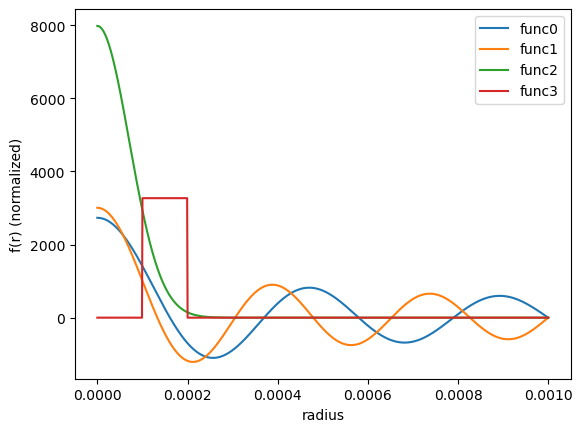

In [37]:
for ifunc, normfunc in enumerate([mynormfunc1, mynormfunc2, mynormfunc3, mynormfunc4]):
    label = f'func{ifunc}'
    # label += f'; int = {integrate_area_abs2(fs_mechanical_2D[ik]):.02f}'
    plt.plot(rs,normfunc(rs), label=label)
plt.xlabel('radius')
plt.ylabel('f(r) (normalized)')
plt.legend()
plt.show()

##### apply to orthonormal basis

In [88]:
# domain boundary
Rmax = 1e-3

In [89]:
# coordinates
nr = 2001
rs = np.linspace(0, Rmax,nr)
print(f'dr = {Rmax/(nr-1):.2e}')

dr = 5.00e-07


In [90]:
# transverse mode numbers of Bessel modes
kmin = 0
kmax = 101 # transverse mode number of Bessel modes
ks = range(kmin,kmax+1)
j0_zeros = jn_zeros(0, kmax+1)

In [91]:
# this 'function maker' is needed because otherwise (using normalize_spatialfunc_2D directly in a loop), k is only evaluated at the end of the loop!
# not needed for optical mode if we only use one (not a list)
def make_Besselfunc_norm_2D(k, R):
    return normalize_spatialfunc_radial_2D(lambda r: jv(0,j0_zeros[k]*r/R), Rmax)

WATCH OUT: Bessel functions are a complete orthonormal basis only for r in [0,R], using the definition lambda r: jv(0,j0_zeros[k]*r/R). If in your overlap integrals you integrate further/less than that, they are not orthonormal anymore!

In [102]:
# waist_opt = 77e-6 / np.sqrt(2)
waist_opt = 8e-5
# waist_opt = 2e-4
func_optical_2D = normalize_spatialfunc_radial_2D(lambda r: np.exp(-r**2/waist_opt**2), Rmax)

In [103]:
r_inner = 2e-4
r_outer = 2.5e-4
func_ring_2D = normalize_spatialfunc_radial_2D(np.vectorize(lambda r: 1 if (r_inner <= r) * (r < r_outer) else 0), Rmax)

In [104]:
funcs_mechanical_2D = [make_Besselfunc_norm_2D(k, Rmax) for k in ks]

In [105]:
gs = np.array([overlap_integral_radial_2D(func_optical_2D, funcs_mechanical_2D[ik],Rmax) for ik in range(len(ks))])
print(f'sum of all |g|^2 = {sum(abs(gs)**2)}')
igmax = np.argmax(gs)
print(f'g is maximal for k = {ks[igmax]}')

sum of all |g|^2 = 0.9999999953760833
g is maximal for k = 3


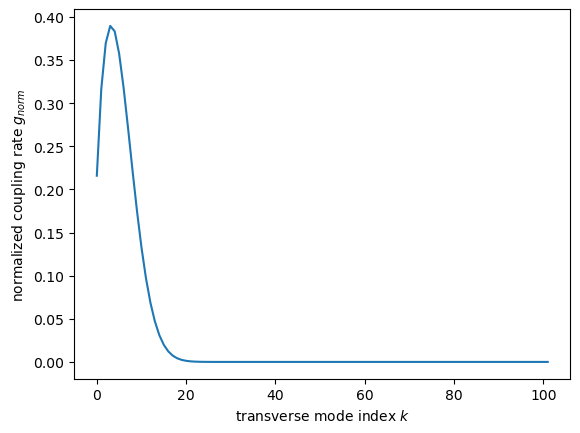

In [106]:
plt.plot(gs)
plt.xlabel('transverse mode index $k$')
plt.ylabel('normalized coupling rate $g_{norm}$')
plt.show()

### 2D, arbitrary function, defined on grid

In [43]:
def integrate_area_arb_2D(field, xs, ys):
    return np.trapz(np.trapz(field, x=xs, axis=1), x=ys, axis=0)

def integrate_area_abs2_arb_2D(field, xs, ys):
    return integrate_area_arb_2D(abs(field)**2, xs, ys)

def normalize_spatialfield_arb_2D(field, xs, ys):
    N = integrate_area_abs2_arb_2D(field, xs, ys)
    return 1/np.sqrt(N) * field

def overlap_integral_arb_2D(field1, field2, xs, ys):
    return integrate_area_arb_2D(field1*field2, xs, ys)

#### some tests

In [63]:
# domain boundaries
Xmax = 1e-3
Ymax = 1e-3

In [64]:
# coordinates
nx = 1001
ny = 1003
xs = np.linspace(-Xmax, Xmax, nx)
ys = np.linspace(-Ymax, Ymax, ny)
Xs, Ys = np.meshgrid(xs, ys)

In [65]:
# transverse mode numbers of Bessel modes
kmin = 0
kmax = 101 # transverse mode number of Bessel modes
ks = range(kmin,kmax+1)
j0_zeros = jn_zeros(0, kmax+1)

In [76]:
k1=4
k2=5
R = Xmax
myfield1 = jv(0,j0_zeros[k1]*np.sqrt(Xs**2 + Ys**2)/R)
myfield2 = jv(0,j0_zeros[k2]*np.sqrt(Xs**2 + Ys**2)/R)
w=1e-4
x0 = 0 #0.1*Xmax
y0 = 0
myfield3 = np.exp(-((Xs - x0)**2 + (Ys - y0)**2)/w**2)

In [77]:
integrate_area_arb_2D(myfield1, xs, ys)

2.403479486884072e-08

In [78]:
integrate_area_abs2_arb_2D(myfield1, xs, ys)

1.496115218670345e-07

In [79]:
mynormfield1 = normalize_spatialfield_arb_2D(myfield1, xs, ys)
mynormfield2 = normalize_spatialfield_arb_2D(myfield2, xs, ys)
mynormfield3 = normalize_spatialfield_arb_2D(myfield3, xs, ys)
integrate_area_abs2_arb_2D(mynormfield2, xs, ys)

1.0000000000000002

In [80]:
overlap_integral_arb_2D(mynormfield1, mynormfield2, xs, ys)

-0.09294249067823436

this does not go all the way to 0, since we are not strictly integrating over r :elem: [0,R]

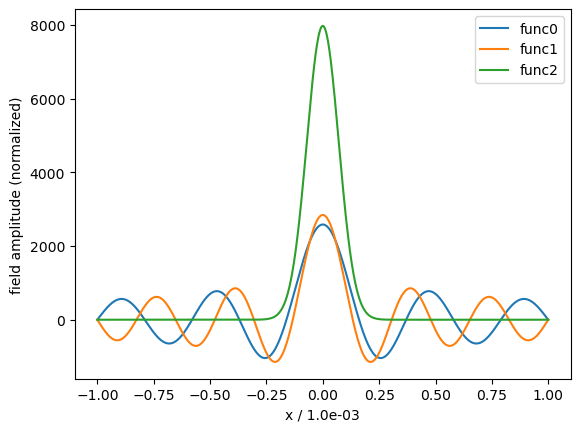

In [82]:
iy = int((ny-1)/2 - 1)
for ifield, normfield in enumerate([mynormfield1, mynormfield2, mynormfield3]):
    label = f'func{ifield}'
    plt.plot(xs/Xmax,normfield[iy,:], label=label)
plt.xlabel(f'x / {Xmax:.1e}')
plt.ylabel('field amplitude (normalized)')
plt.legend()
plt.show()

#### application to orthonormal basis

In [83]:
# domain boundaries
# Xmax = 1e-2
Xmax = 4.5e-3
Ymax = Xmax
# Ymax = 1e-3

In [84]:
# coordinates
nx = 601
ny = 603
xs = np.linspace(-Xmax, Xmax, nx)
ys = np.linspace(-Ymax, Ymax, ny)
Xs, Ys = np.meshgrid(xs, ys)

In [85]:
# transverse mode numbers of Bessel modes
kmin = 0
kmax = 121 # transverse mode number of Bessel modes
ks = range(kmin,kmax+1)
j0_zeros = jn_zeros(0, kmax+1)

In [90]:
# waist_opt = 77e-6 / np.sqrt(2)
# waist_opt = 5e-5
waist_opt = 1e-4

R = Xmax

In [91]:
field_optical_2D = normalize_spatialfield_arb_2D(np.exp(-(Xs**2 + Ys**2)/waist_opt**2), xs, ys)

fields_mechanical_2D = [normalize_spatialfield_arb_2D(jv(0,j0_zeros[k]*np.sqrt(Xs**2 + Ys**2)/R), xs, ys) for k in ks]

In [92]:
gs = np.array([overlap_integral_arb_2D(field_optical_2D, fields_mechanical_2D[ik],xs, ys) for ik in range(len(ks))])
# print(f'sum of all g = {sum(gs)}')
print(f'sum of all |g|^2 = {sum(abs(gs)**2)}')
igmax = np.argmax(gs)
print(f'g is maximal for k = {ks[igmax]}')

sum of all |g|^2 = 0.8930353340072433
g is maximal for k = 14


sum of g^2 is:
- indep of nx/ny, if spacing is small enough for good resolution
- indep of using function builder
- almost independent on #ks, as long as they cover the range of couplings
- basically independent on waist_opt, just up to the point where it shifts the range of couplings

- for too small diam and/or waist_opt, dependent on x&y spacing (can give second peak in gs vs ks plot)

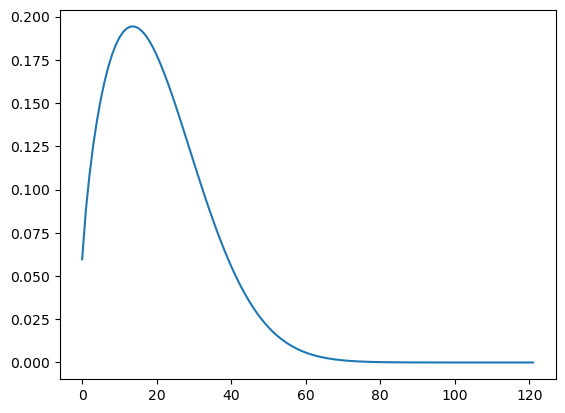

In [93]:
plt.plot(gs)
plt.xlabel('transverse mode index $k$')
plt.ylabel('normalized coupling rate $g_{norm}$')
plt.show()

### 2D, arbitrary function, defined in polar coordinates

In [177]:
def integrate_area_arb_polar_2D(field, rs, phis):
    Rg, _ = np.meshgrid(rs,phis)
    return np.trapz(np.trapz(Rg*field, x=rs, axis=1), x=phis, axis=0)

def integrate_area_abs2_arb_polar_2D(field, rs, phis):
    return integrate_area_arb_polar_2D(abs(field)**2, rs, phis)

def normalize_spatialfield_arb_polar_2D(field, rs, phis):
    N = integrate_area_abs2_arb_polar_2D(field, rs, phis)
    return 1/np.sqrt(N) * field

def overlap_integral_arb_polar_2D(field1, field2, rs, phis):
    return integrate_area_arb_polar_2D(field1*field2, rs, phis)

#### apply to orthonormal basis

In [178]:
Rmax = 9e-3

nr = 203
nphi = 201
rs = np.linspace(0, Rmax, nr)
phis = np.linspace(0, 2*np.pi, nphi, endpoint=False)
Rs, Phis = np.meshgrid(rs, phis)

In [179]:
# transverse mode numbers of Bessel modes
kmin = 0
kmax = 101 # transverse mode number of Bessel modes
ks = range(kmin,kmax+1)
j0_zeros = jn_zeros(0, kmax+1)

WATCH OUT: Bessel functions are a complete orthonormal basis only for r in [0,R], using the definition lambda r: jv(0,j0_zeros[k]*r/R). If in your overlap integrals you integrate further/less than that, they are not orthonormal anymore!

In [238]:
waist_opt = 5e-4

r_inner = 1e-3
r_outer = 1.4e-3

R = Rmax

In [239]:
field_optical_2D = normalize_spatialfield_arb_polar_2D(np.exp(-Rs**2/waist_opt**2), rs, phis)

fun = np.vectorize(lambda r: 1 if (r_inner <= r) * (r < r_outer) else 0)
field_ring_2D = normalize_spatialfield_arb_polar_2D(fun(Rs), rs, phis)

fields_mechanical_2D = np.array([normalize_spatialfield_arb_polar_2D(jv(0,j0_zeros[k]*np.sqrt(Rs**2)/R), rs, phis) for k in ks])

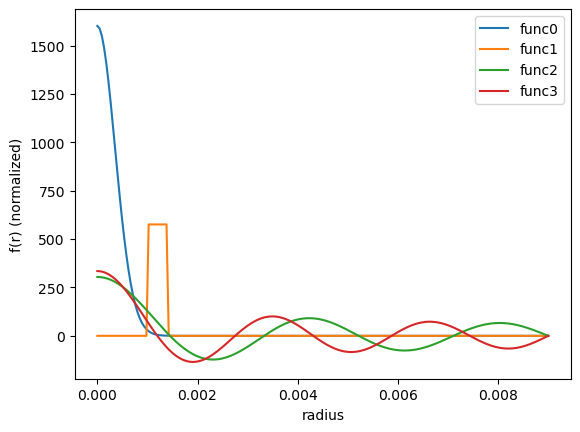

In [240]:
for ifield, normfield in enumerate([field_optical_2D, field_ring_2D, *fields_mechanical_2D[[4,5]]]):
    label = f'func{ifield}'
    # label += f'; int = {integrate_area_abs2(fs_mechanical_2D[ik]):.02f}'
    plt.plot(rs,normfield[0,:], label=label)
plt.xlabel('radius')
plt.ylabel('f(r) (normalized)')
plt.legend()
plt.show()

In [245]:
gs_opt = np.array([overlap_integral_arb_polar_2D(field_optical_2D, fields_mechanical_2D[ik],rs,phis) for ik in range(len(ks))])
gs_ring = np.array([overlap_integral_arb_polar_2D(field_ring_2D, fields_mechanical_2D[ik],rs,phis) for ik in range(len(ks))])
print(f'sum of all |g_opt|^2 = {sum(abs(gs_opt)**2)}')
print(f'sum of all |g_ring|^2 = {sum(abs(gs_ring)**2)}')
igoptmax = np.argmax(gs_opt)
igringmax = np.argmax(gs_ring)
print(f'g_opt is maximal for k = {ks[igoptmax]}')
print(f'g_ring is maximal for k = {ks[igringmax]}')

sum of all |g_opt|^2 = 0.9977857883483877
sum of all |g_ring|^2 = 0.9622761535596421
g_opt is maximal for k = 5
g_ring is maximal for k = 1


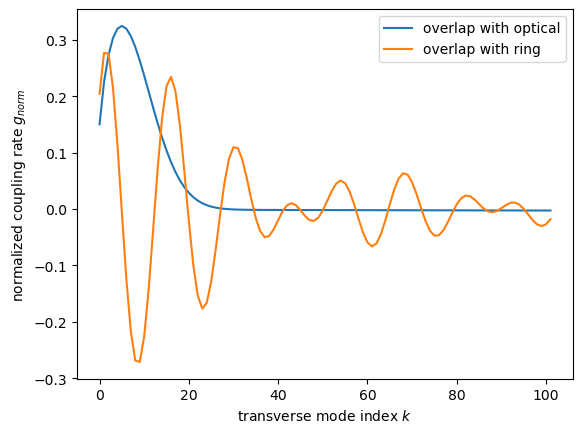

In [248]:
plt.plot(gs_opt, label='overlap with optical')
plt.plot(gs_ring, label='overlap with ring')
plt.xlabel('transverse mode index $k$')
plt.ylabel('normalized coupling rate $g_{norm}$')
plt.legend()
plt.show()